In [1]:
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torch import Generator

In [2]:
vocab_size=27
hidden_neurons=200
embed_size=4
block_size=4
batch_size=64


In [3]:
class Linear:
    def __init__(self,fan_in,fan_out,no_bias=False,seed=276458207):
        g=Generator().manual_seed(seed)
        self.no_bias = no_bias
        self.w=torch.randn((fan_in,fan_out),generator=g) / (fan_in**0.5)
        self.b=torch.randn((fan_out,),generator=g)  / (fan_in**0.5)
    def __call__(self,X):
        self.out= X @ self.w
        if not self.no_bias:
            self.out += self.b
        return self.out
    def parameters(self):
        parameter = [self.w] if self.no_bias else [self.w , self.b]
        return parameter

class BatchNorm1D:
    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps=eps
        self.momentum=momentum
        self.gamma = torch.ones((dim))
        self.beta = torch.zeros((dim))
        self.running_mean= torch.zeros((dim))
        self.running_var=  torch.ones((dim))
        self.training=True
    def __call__(self, X:torch.Tensor):
        if self.training:
            xmean=X.mean(0,keepdim=True)
            xvar=X.var(0,keepdim=True)
        else:
            xmean=self.running_mean
            xvar=self.running_var
        xstd=torch.sqrt(xvar+self.eps)
        self.out=self.gamma * (X-xmean)/xstd + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1-self.momentum) + xmean*self.momentum
                self.running_var = self.running_var * (1-self.momentum) + xvar*self.momentum
        return self.out
    
    def parameters(self):
        return [self.gamma,self.beta]

class Tanh:
    def parameters(self):
        return []
    def __call__(self, X:torch.Tensor):
        self.out = X.tanh()
        return self.out

In [4]:
C=torch.randn((vocab_size,embed_size))
layers = [
    Linear(embed_size * block_size , hidden_neurons),BatchNorm1D(hidden_neurons),   Tanh(),
    Linear(hidden_neurons , hidden_neurons),BatchNorm1D(hidden_neurons),            Tanh(),
    Linear(hidden_neurons , hidden_neurons),BatchNorm1D(hidden_neurons),            Tanh(),
    Linear(hidden_neurons , hidden_neurons),BatchNorm1D(hidden_neurons),            Tanh(),
    Linear(hidden_neurons , hidden_neurons),BatchNorm1D(hidden_neurons),            Tanh(),
    Linear(hidden_neurons , vocab_size),BatchNorm1D(vocab_size)
]
layers[-1].gamma *= 0.1
for layer in layers:
    if isinstance(layer,Linear):
        layer.w *= 5/3
parameters=[C]+[p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad=True

In [5]:
import random
names=open('names.txt','r').read().splitlines()
chars=sorted(list(set(''.join(names))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
def build_tensor(words):
    X,y=[],[]
    for word in words:
        word = list(word) + ['.']
        context=[0] * block_size
        for w in word:
            X.append(context)
            idx=stoi[w]
            y.append(idx)
            context=context[1:]+[idx]
    X=torch.tensor(X)
    y=torch.tensor(y)
    return X,y
random.seed(42)
random.shuffle(names)
n1=int(0.8 * len(names))
n2=int(0.9 * len(names))

x_train,y_train=build_tensor(names[:n1])
x_val,y_val=build_tensor(names[n1:n2])
x_test,y_test=build_tensor(names[n2:])

print("Training : ",x_train.shape,y_train.shape)
print("Validation : ",x_val.shape,y_val.shape)
print("Testing : ",x_test.shape,y_test.shape)


Training :  torch.Size([182625, 4]) torch.Size([182625])
Validation :  torch.Size([22655, 4]) torch.Size([22655])
Testing :  torch.Size([22866, 4]) torch.Size([22866])


In [6]:
ud=[]
for i in range (60000):
    ix=torch.randint(0,x_train.shape[0],(batch_size,))
    X=x_train[ix]
    y=y_train[ix]
    z=torch.cat(C[X].unbind(1),1)
    
    lr=0.1 if i<30000 else 0.01
    for layer in layers:
        z=layer(z)
    loss=F.cross_entropy(z,y)
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad=None
        
    loss.backward()
    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])
    for p in parameters:
        
        p.data -= lr * p.grad
    if i%1000==0 and i>0:
        print(f"Loss {i} : ",loss.item())
        break

Loss 1000 :  2.3763153553009033


Layer 2 (      Tanh): mean +0.00 , std 0.64 , saturated 2.77%
Layer 5 (      Tanh): mean +0.00 , std 0.64 , saturated 2.40%
Layer 8 (      Tanh): mean +0.00 , std 0.65 , saturated 2.30%
Layer 11 (      Tanh): mean +0.00 , std 0.65 , saturated 2.09%
Layer 14 (      Tanh): mean -0.00 , std 0.65 , saturated 2.17%


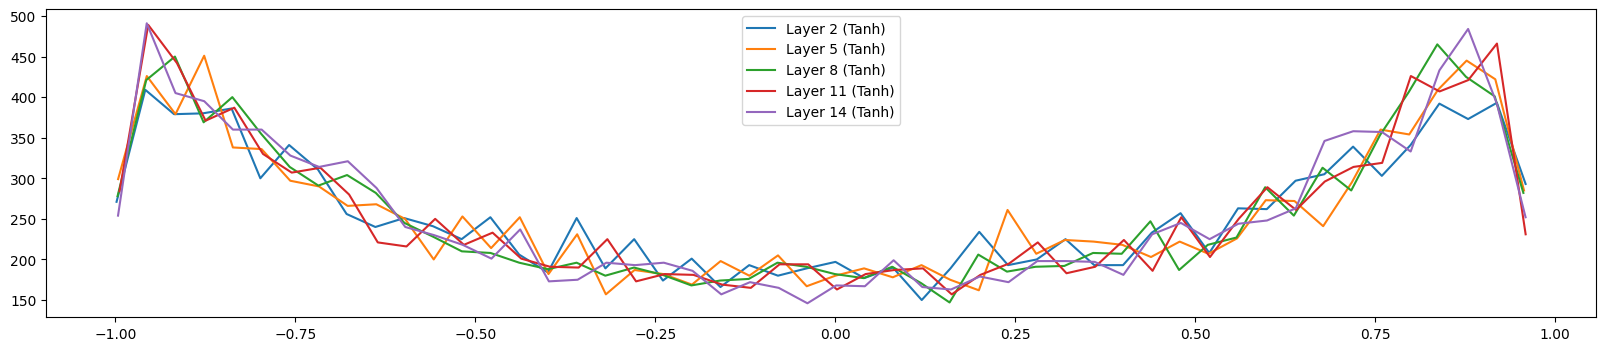

In [7]:
plt.figure(figsize=(20,4))
legends=[]
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t=layer.out
        print("Layer %d (%10s): mean %+.2f , std %.2f , saturated %.2f%%"
                % (i,
                    layer.__class__.__name__,
                    t.mean().item(),
                    t.std().item(),
                    (t.abs() > 0.97).float().mean().item() * 100))
        hy,hx=torch.histogram(t,bins=50)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f"Layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.show()

Layer 2 (      Tanh) : mean 0.00 | std 0.00 | saturation 0.00%
Layer 5 (      Tanh) : mean -0.00 | std 0.00 | saturation 0.00%
Layer 8 (      Tanh) : mean -0.00 | std 0.00 | saturation 0.00%
Layer 11 (      Tanh) : mean 0.00 | std 0.00 | saturation 0.00%
Layer 14 (      Tanh) : mean 0.00 | std 0.00 | saturation 0.00%


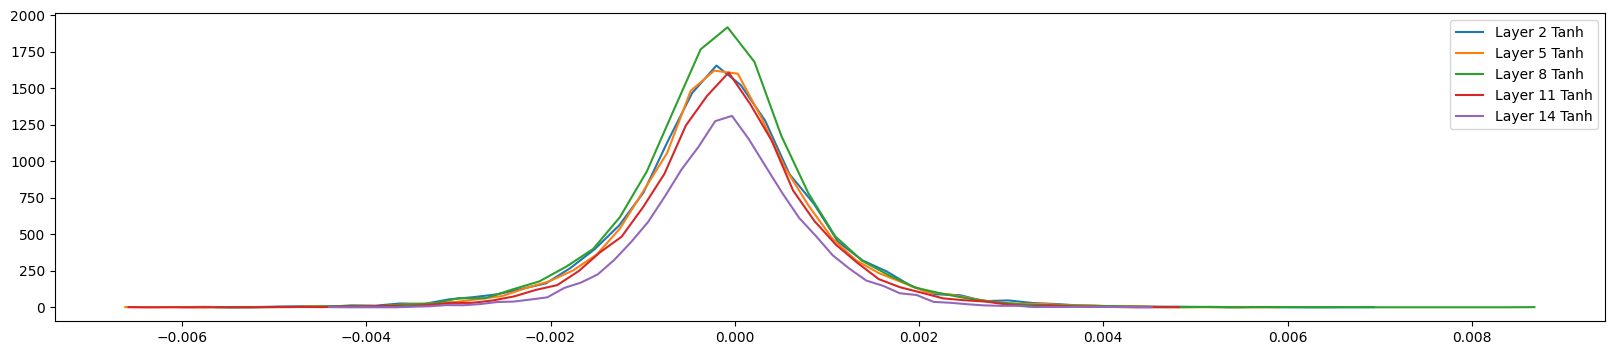

In [8]:
plt.figure(figsize=(20,4))
legends=[]
for i,layer in enumerate(layers):
    if isinstance(layer,Tanh):
        t=layer.out.grad
        print("Layer %d (%10s) : mean %.2f | std %.2f | saturation %.2f%%"
              %(i,layer.__class__.__name__,t.mean().item(),t.std().item(),
                (t.abs()>0.97).float().mean().item() * 100))
        hy,hx=torch.histogram(t,50)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f"Layer {i} {layer.__class__.__name__}")
plt.legend(legends)
plt.show()

C:\Users\Rikan\AppData\Local\Temp\ipykernel_19160\3155810464.py:6: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  print("Layer%d %10s : mean %.2f , std %.2f , grad:data %.5f"%(i,tuple(p.shape),t.mean().item(),t.std().item(),t.std()/p.std()))


Layer0    (27, 4) : mean 0.00 , std 0.01 , grad:data 0.00904
Layer1  (16, 200) : mean 0.00 , std 0.00 , grad:data 0.00916
Layer5 (200, 200) : mean -0.00 , std 0.00 , grad:data 0.02681
Layer9 (200, 200) : mean 0.00 , std 0.00 , grad:data 0.02669
Layer13 (200, 200) : mean 0.00 , std 0.00 , grad:data 0.02643
Layer17 (200, 200) : mean 0.00 , std 0.00 , grad:data 0.02428
Layer21  (200, 27) : mean -0.00 , std 0.01 , grad:data 0.06440


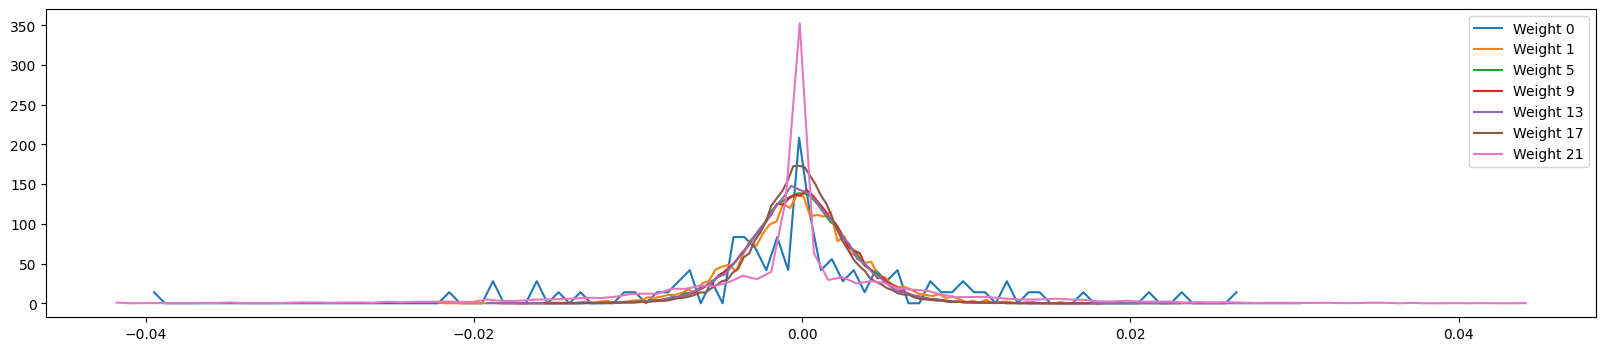

In [9]:
plt.figure(figsize=(20,4))
legends=[]
for i,p in enumerate(parameters):
    if p.ndim==2:
        t=p.grad
        print("Layer%d %10s : mean %.2f , std %.2f , grad:data %.5f"%(i,tuple(p.shape),t.mean().item(),t.std().item(),t.std()/p.std()))
        hy,hx=torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f"Weight {i}")
plt.legend(legends)
plt.show()

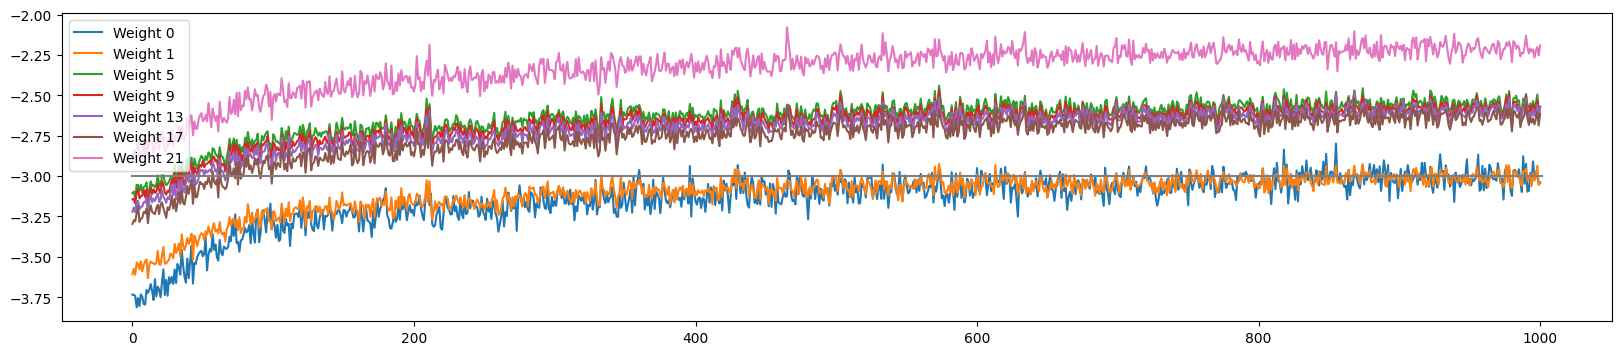

In [10]:
plt.figure(figsize=(20,4))
legends=[]
for i,p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("Weight %d"%i)
plt.plot([0,len(ud)],[-3,-3])
plt.legend(legends)
plt.show()

In [69]:
#Training
z_train=torch.cat(C[x_train].unbind(1),1)
for layer in layers:
    z_train=layer(z_train)  
training_loss=F.cross_entropy(z_train,y_train)

# Validation
z_val=torch.cat(C[x_val].unbind(1),1)
for layer in layers:
    z_val=layer(z_val)  
validation_loss=F.cross_entropy(z_val,y_val)

#Testing
z_test=torch.cat(C[x_test].unbind(1),1)
for layer in layers:
    z_test=layer(z_test)  
testing_loss=F.cross_entropy(z_test,y_test)


print("Training Loss = ",training_loss.item())
print("Validation Loss = ",validation_loss.item())
print("Testing Loss = ",testing_loss.item())

Training Loss =  2.06016206741333
Validation Loss =  2.1142849922180176
Testing Loss =  2.107623338699341


# Loss Markdown
### Test 1
Training Loss =  1.9478812217712402 
Validation Loss =  2.058687448501587
Testing Loss =  2.058717727661133

### Test 2 (With Batch Normalization)
Training Loss =  2.06016206741333
Validation Loss =  2.1142849922180176
Testing Loss =  2.107623338699341